Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from ucimlrepo import fetch_ucirepo
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset

Preprocess Dataset

In [2]:

def fetch_and_clean_data(task_type):
    if task_type == 'classification':
        # Fetch UCI Adult dataset
        adult = fetch_ucirepo(id=2)
        X = adult.data.features
        y = adult.data.targets.squeeze()  # Remove unnecessary axis
        
        # Clean the data
        X = X.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                              'hours-per-week': 'hours', 'marital-status': 'marital'})
        X = X.replace('?', pd.NA)  # Replace '?' with NaN
        X = X.dropna()  # Drop rows with missing values
        y = y.loc[X.index]
        
        # Map target labels for binary classification
        y = y.map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
        
        # Normalize numerical features
        numerical_features = ['age', 'fnlwgt', 'education-num', 'gain', 'loss', 'hours']
        scaler = MinMaxScaler()
        X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    elif task_type == 'regression':
        # Fetch UCI Student Performance dataset
        student = fetch_ucirepo(id=320)
        X = student.data.features
        y = student.data.targets['G3']  # Predict the 'G3' grade
        
        # Clean the data
        X = X.replace('?', pd.NA)  # Replace '?' with NaN
        X = X.dropna()  # Drop rows with missing values
        y = y.loc[X.index]
        
        # Normalize numerical features
        numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
                              'goout', 'Dalc', 'Walc', 'health', 'absences']
        scaler = MinMaxScaler()
        X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Encode categorical features
    X_encoded = pd.get_dummies(X).astype(float)
    if task_type == 'regression':
        X_encoded = X_encoded.rename(columns={'sex_F': 'sex_Female', 'sex_M': 'sex_Male'})
    
    # Balance the dataset for men and women
    if 'sex_Female' in X_encoded.columns and 'sex_Male' in X_encoded.columns:
        female_indices = X_encoded[X_encoded['sex_Female'] == 1].index
        male_indices = X_encoded[X_encoded['sex_Male'] == 1].index
        
        # Undersample the larger class
        if len(female_indices) > len(male_indices):
            female_indices = resample(female_indices, replace=False, n_samples=len(male_indices), random_state=42)
        elif len(male_indices) > len(female_indices):
            male_indices = resample(male_indices, replace=False, n_samples=len(female_indices), random_state=42)
        
        # Combine indices to keep balanced dataset
        balanced_indices = female_indices.union(male_indices)
        X_encoded = X_encoded.loc[balanced_indices]
        y = y.loc[balanced_indices]

    return X_encoded.reset_index(drop=True), y.reset_index(drop=True)


Define Binary Classification Model

In [3]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Training the logistic regression model
def train_classification_model(X_train, y_train, input_dim, lr=0.1, epochs=10000):
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)
    
    loss_values = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())

    # Plot loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

# Function to predict using the PyTorch model
def predict_classification_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        probabilities = model(X_tensor).squeeze()
        predictions = (probabilities >= 0.5).float()
    return predictions.numpy()


Define Regression Model

In [19]:
# Define a Neural Network Model with Dropout and L2 Regularization
# Define a Neural Network Model with Dropout and Multiple Hidden Layers
class MultiLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_prob=0.5):
        super(MultiLayerNN, self).__init__()
        # Define the first hidden layer
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        # Define the second hidden layer
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Define the output layer
        self.output = nn.Linear(hidden_dim2, 1)
        # Define activation function and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Dropout after the first hidden layer
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Dropout after the second hidden layer
        x = self.output(x)
        return x

# Function to train the model with early stopping
def train_regression_model(X_train, y_train, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_prob=0.5, lr=0.001, weight_decay=0.01, epochs=1000, patience=30):
    # Split training data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Create the model
    model = MultiLayerNN(input_dim, hidden_dim1, hidden_dim2, dropout_prob)
    
    # Loss function and optimizer with L2 regularization (weight_decay)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Convert training and validation data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_split.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train_split).values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_split.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(pd.to_numeric(y_val_split).values, dtype=torch.float32).view(-1, 1)

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    train_loss_values = []
    val_loss_values = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        
        # Average loss for this epoch
        avg_train_loss = train_epoch_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_loss_values.append(val_loss.item())

        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss.item():.4f}')
        
        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Plot loss values
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_loss_values)), train_loss_values, label='Train Loss')
    plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss per Epoch')
    plt.legend()
    plt.show()

    return model

# Function to predict using the trained model
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_tensor).squeeze()
    return predictions.numpy()


Train and Evaluate generic (h_0) and personalized (h_p) models 

In [4]:
#################### Main Workflow ####################
def train_and_evaluate_model(task_type):
    # Step 1: Fetch, clean, and preprocess data
    X_encoded, y_cleaned = fetch_and_clean_data(task_type)

    # Step 2: Split the data into training and testing sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_encoded, y_cleaned, test_size=0.3, random_state=42)
    excluded_columns = ['sex_Female', 'sex_Male']
    X_train_h0, X_test_h0 = X_train_hp.drop(columns=excluded_columns), X_test_hp.drop(columns=excluded_columns)

    if task_type == 'classification':
        print("Running classification task")
        print("Training and evaluating hp...")
        # HP
        model_hp = train_classification_model(X_train_hp, y_train, X_train_hp.shape[1])
        evaluate_model_classification(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")
        print("Training and evaluating h0...")
        # H0
        model_h0 = train_classification_model(X_train_h0, y_train, X_train_h0.shape[1])
        evaluate_model_classification(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    elif task_type == 'regression':
        print("Running regression task")
        print("Training and evaluating hp...")
        # HP
        model_hp = train_regression_model(X_train_hp, y_train, X_train_hp.shape[1])
        evaluate_model_regression(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")
        print("Training and evaluating h0...")
        # H0
        model_h0 = train_regression_model(X_train_h0, y_train, X_train_h0.shape[1])
        evaluate_model_regression(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0

def evaluate_model_classification(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_classification_model(model, X_train)
    y_test_pred = predict_classification_model(model, X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Plot confusion matrix for test data
    test_cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(test_cm).plot()
    plt.title(f'Confusion Matrix - Test Data ({model_name})')
    plt.show()

    # Print accuracy results
    print(f"Training Accuracy {model_name}: {train_accuracy:.4f}")
    print(f"Test Accuracy {model_name}: {test_accuracy:.4f}")

def evaluate_model_regression(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data using the predict_regression_model function
    y_train_pred = predict_model(model, X_train)
    y_test_pred = predict_model(model, X_test)

    # Calculate regression metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Plot predictions vs true values for test data
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predictions vs True Values - Test Data ({model_name})')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
    plt.show()

    # Print regression metrics
    print(f"{model_name} - Training MSE: {train_mse:.4f}")
    print(f"{model_name} - Test MSE: {test_mse:.4f}")


Find Results per Sex

In [5]:
# Function to filter data based on sex and calculate cost
def evaluate_model_for_sex(y_preds, y_val, sex_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions for a specific sex group using a custom cost function (classification or regression).
    """
    # Use the provided sex indices to filter the predictions and true values
    y_sex_pred = y_preds[sex_indices]
    y_sex_val = y_val[sex_indices]

    # Compute the element-wise loss using the custom cost function

    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_sex_val, y_sex_pred)])
    if comprehensiveness:
        individual_losses = 1/individual_losses
    total_loss = np.mean(individual_losses)

    return total_loss, y_sex_pred, y_sex_val

def evaluate_model_by_sex(y_preds, y_val, female_indices, male_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions by sex using a custom cost function for classification or regression.
    """
    # Evaluate predictions for female subjects using pre-computed indices
    female_loss, female_preds, female_true = evaluate_model_for_sex(y_preds, y_val, female_indices, cost_function, comprehensiveness)

    # Evaluate predictions for male subjects using pre-computed indices
    male_loss, male_preds, male_true = evaluate_model_for_sex(y_preds, y_val, male_indices, cost_function, comprehensiveness)

    return female_loss, male_loss, (female_preds, female_true), (male_preds, male_true)

def compare_models_by_sex(y_preds_hp, y_preds_h0, X_test_hp, y_val_hp, y_val_h0, cost_function, comprehensiveness=False):
    """
    Compare two models' predictions by sex using a custom cost function for classification or regression.
    """
    # Calculate female and male indices based on X_test_hp (which has the sex columns)
    female_indices = X_test_hp['sex_Female'] == 1
    male_indices = X_test_hp['sex_Male'] == 1

    total_loss_hp = np.mean(np.array([cost_function(true, pred) for true, pred in zip(y_val_hp, y_preds_hp)]))
    total_loss_h0 = np.mean(np.array([cost_function(true, pred) for true, pred in zip(y_val_h0, y_preds_h0)]))
    if comprehensiveness:
        total_loss_hp = 1/total_loss_hp
        total_loss_h0 = 1/total_loss_h0

    # Evaluate predictions from model 1 (h_p) using the indices from X_test_hp
    female_loss_hp, male_loss_hp, (female_preds_1, female_true_1), (male_preds_1, male_true_1) = evaluate_model_by_sex(
        y_preds_hp, y_val_hp, female_indices, male_indices, cost_function, comprehensiveness)

    # Evaluate predictions from model 2 (h_0) using the same indices applied to X_test_h_0
    female_loss_h0, male_loss_h0, (female_preds_2, female_true_2), (male_preds_2, male_true_2) = evaluate_model_by_sex(
        y_preds_h0, y_val_h0, female_indices, male_indices, cost_function, comprehensiveness)

    # Print results and calculate differences as before
    print(f"Model h_p - Female {cost_function.__name__}: {female_loss_hp:.4f}, Male {cost_function.__name__}: {male_loss_hp:.4f}")
    print(f"Model h_0 - Female {cost_function.__name__}: {female_loss_h0:.4f}, Male {cost_function.__name__}: {male_loss_h0:.4f}")
    male_loss_dif = male_loss_h0 - male_loss_hp
    female_loss_dif = female_loss_h0 - female_loss_hp
    loss_diff = total_loss_h0 - total_loss_hp
    print(f"Female loss difference {female_loss_dif:.4f}")
    print(f"Male loss difference {male_loss_dif:.4f}")
    print(f"Total loss h_p: {total_loss_hp:.4f}")
    print(f"Total loss h_0: {total_loss_h0:.4f}")
    print(f"Total loss difference: {loss_diff:.4f}")

    return (female_loss_hp, male_loss_hp), (female_loss_h0, male_loss_h0), female_loss_dif, male_loss_dif


Plot Individual Loss Differences per Sex

In [6]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, sex_indices, cost_function, title):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given sex using a custom cost function.
    """
    # Filter predictions and true values for the selected sex (male/female)
    y_preds_h0_filtered = y_preds_h0[sex_indices]
    y_preds_hp_filtered = y_preds_hp[sex_indices]
    y_vals_h0_filtered = y_val_h0[sex_indices]
    y_vals_hp_filtered = y_val_hp[sex_indices]

    if title == "Comprehensiveness":
        # Reciprocal the losses for comprehensiveness
        individual_diff = np.array([1/cost_function(val_h0, pred_h0) - 1/cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    else:
        # Compute individual element-wise losses using the custom cost function
        individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    return individual_diff

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for men and women using a custom element-wise cost function.
    """
    female_indices = X_test_hp['sex_Female'] == 1
    print("Number of females: ", sum(female_indices))
    male_indices = X_test_hp['sex_Male'] == 1
    print("Number of males", sum(male_indices))

    # Compute loss differences for females
    female_loss_diff = individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, female_indices, cost_function, title)
    std_dev_f = np.std(female_loss_diff)
    print("standard deviation for females: ", std_dev_f)
    
    # Compute loss differences for males
    male_loss_diff = individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, male_indices, cost_function, title)
    print("Mean of male_loss_diff: ", np.mean(male_loss_diff))
    std_dev_m = np.std(male_loss_diff)
    print("standard deviation for males: ", std_dev_m)
    
    # Plot histogram for females
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(female_loss_diff, bins=30, alpha=0.7, color='blue')
    plt.title(f'{cost_function.__name__} Difference Histogram for Females for {title}')
    plt.xlabel('Difference in Loss/Accuracy')
    plt.ylabel('Frequency')
    
    # Plot histogram for males
    plt.subplot(1, 2, 2)
    plt.hist(male_loss_diff, bins=30, alpha=0.7, color='green')
    plt.title(f'{cost_function.__name__} Difference Histogram for Males for {title}')
    plt.xlabel('Difference in Loss/Accuracy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


Run Explainer, Comprehensiveness and Sufficiency

In [7]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions


In [8]:
def plot_loss_by_sex_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, cost_function, ks):
    male_loss_hp_comp_list = []
    male_loss_h0_comp_list = []
    female_loss_hp_comp_list = []
    female_loss_h0_comp_list = []
    
    male_loss_hp_suff_list = []
    male_loss_h0_suff_list = []
    female_loss_hp_suff_list = []
    female_loss_h0_suff_list = []
    
    for top_k in ks:
        # Comprehensiveness for model h_p
        comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
        # Comprehensiveness for model h_0
        comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)

        # Compare models by sex for comprehensiveness
        (female_loss_hp_comp, male_loss_hp_comp), (female_loss_h0_comp, male_loss_h0_comp), _, _ = compare_models_by_sex(
            comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function, True
        )

        # Store comprehensiveness losses
        male_loss_hp_comp_list.append(male_loss_hp_comp)
        male_loss_h0_comp_list.append(male_loss_h0_comp)
        female_loss_hp_comp_list.append(female_loss_hp_comp)
        female_loss_h0_comp_list.append(female_loss_h0_comp)
        
        # Sufficiency for model h_p
        sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
        # Sufficiency for model h_0
        sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

        # Compare models by sex for sufficiency
        (female_loss_hp_suff, male_loss_hp_suff), (female_loss_h0_suff, male_loss_h0_suff), _, _ = compare_models_by_sex(
            sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function
        )

        # Store sufficiency losses
        male_loss_hp_suff_list.append(male_loss_hp_suff)
        male_loss_h0_suff_list.append(male_loss_h0_suff)
        female_loss_hp_suff_list.append(female_loss_hp_suff)
        female_loss_h0_suff_list.append(female_loss_h0_suff)

    # Plot comprehensiveness losses over different k values
    plt.figure(figsize=(10, 12))

    # Male loss plot for comprehensiveness
    plt.subplot(2, 2, 1)
    plt.plot(ks, male_loss_hp_comp_list, label='Male Loss h_p (Comp)', marker='o')
    plt.plot(ks, male_loss_h0_comp_list, label='Male Loss h_0 (Comp)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title('Male Comprehensiveness vs Top r Features')
    plt.legend()

    # Female loss plot for comprehensiveness
    plt.subplot(2, 2, 2)
    plt.plot(ks, female_loss_hp_comp_list, label='Female Loss h_p (Comp)', marker='o')
    plt.plot(ks, female_loss_h0_comp_list, label='Female Loss h_0 (Comp)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title('Female Comprehensiveness vs Top r Features')
    plt.legend()

    # Male loss plot for sufficiency
    plt.subplot(2, 2, 3)
    plt.plot(ks, male_loss_hp_suff_list, label='Male Loss h_p (Suff)', marker='o')
    plt.plot(ks, male_loss_h0_suff_list, label='Male Loss h_0 (Suff)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title('Male Sufficiency vs Top r Features')
    plt.legend()

    # Female loss plot for sufficiency
    plt.subplot(2, 2, 4)
    plt.plot(ks, female_loss_hp_suff_list, label='Female Loss h_p (Suff)', marker='o')
    plt.plot(ks, female_loss_h0_suff_list, label='Female Loss h_0 (Suff)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title('Female Sufficiency vs Top r Features')
    plt.legend()

    plt.tight_layout()
    plt.show()


Define Cost Functions

In [9]:
# For scalars
def squared_error(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

Full Run for Classification

Running classification task
Training and evaluating hp...


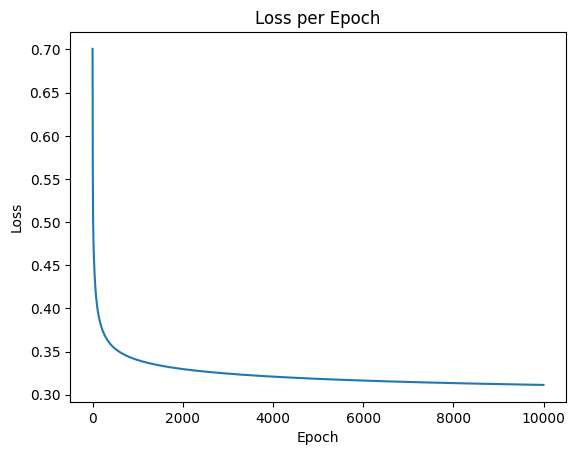

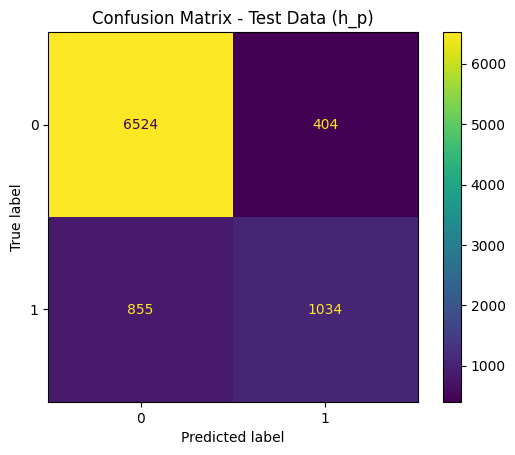

Training Accuracy h_p: 0.8563
Test Accuracy h_p: 0.8572
Training and evaluating h0...


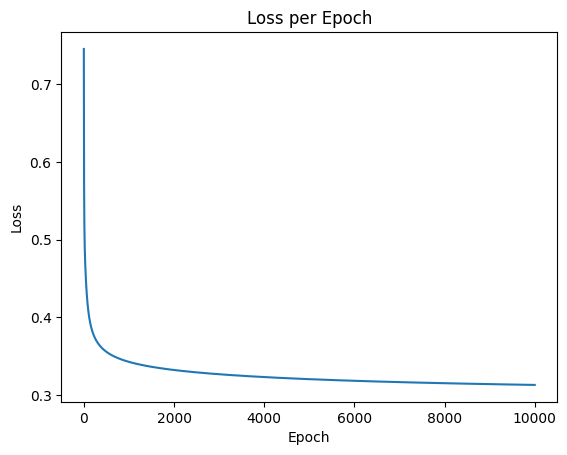

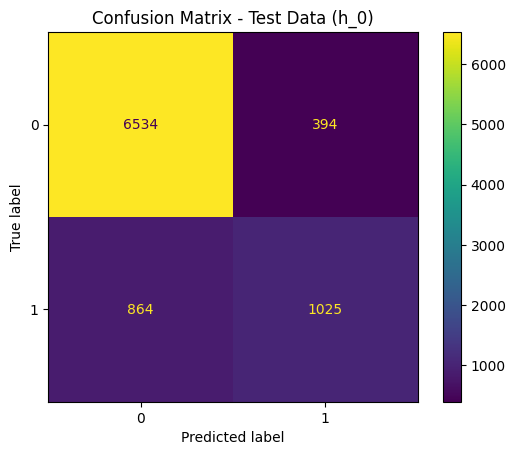

Training Accuracy h_0: 0.8562
Test Accuracy h_0: 0.8573


In [11]:
task_type = 'classification'
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model(task_type)

For test data
Model h_p - Female zero_one_loss: 0.0827, Male zero_one_loss: 0.2032
Model h_0 - Female zero_one_loss: 0.0818, Male zero_one_loss: 0.2039
Female loss difference -0.0009
Male loss difference 0.0007
Total loss h_p: 0.1428
Total loss h_0: 0.1427
Total loss difference: -0.0001
For training data
Number of females:  10272
Number of males:  10301
Model h_p - Female zero_one_loss: 0.0837, Male zero_one_loss: 0.2035
Model h_0 - Female zero_one_loss: 0.0834, Male zero_one_loss: 0.2040
Female loss difference -0.0003
Male loss difference 0.0005
Total loss h_p: 0.1437
Total loss h_0: 0.1438
Total loss difference: 0.0001
Number of females:  4423
Number of males 4394
standard deviation for females:  0.05207948529899495
Mean of male_loss_diff:  0.0006827492034592626
standard deviation for males:  0.10559878870845599


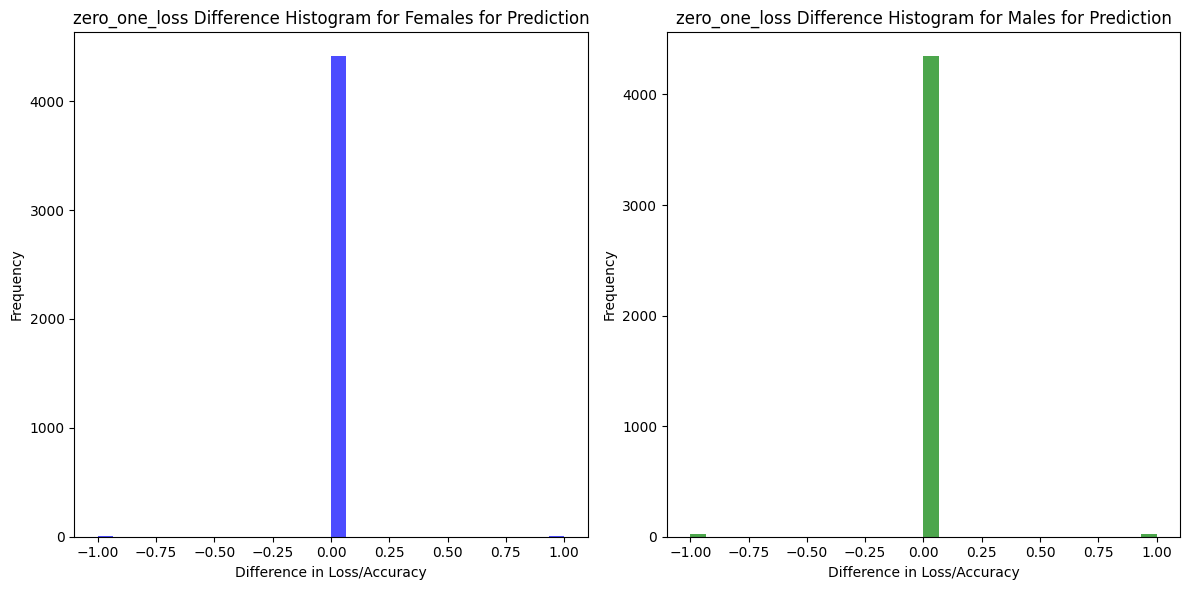

In [12]:
# Step 2: Generate predictions for both models
y_preds_hp = predict_model(model_hp, X_test_hp)
y_preds_h0 = predict_model(model_h0, X_test_h0)

# Assume true values for both models are the same, if not, you can handle them separately
y_test_hp = y_test
y_test_h0 = y_test
    
# Step 3: Compare models by sex using 0-1 loss function for classification
print("For test data")
hp_losses, h0_losses, female_loss_dif, male_loss_dif = compare_models_by_sex(y_preds_hp, y_preds_h0, X_test_hp, y_test_hp, y_test_h0, zero_one_loss)
print("For training data")
y_preds_hp_train = predict_model(model_hp, X_train_hp)
y_preds_h0_train = predict_model(model_h0, X_train_h0)
print("Number of females: ", (X_train_hp['sex_Female'] == 1).sum())
print("Number of males: ", (X_train_hp['sex_Male'] == 1).sum())
y_train_hp = y_train
y_train_h0 = y_train
hp_losses_train, h0_losses_train, _, _, = compare_models_by_sex(y_preds_hp_train, y_preds_h0_train, X_train_hp, y_train_hp, y_train_h0, zero_one_loss)


# Step 4: Plot loss difference histograms for normal model predictions using 0-1 loss
plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, zero_one_loss, "Prediction")

In [13]:
# Step 5: Generate explanations with Integrated Gradients
attributions_hp, _ = explain_with_ig(model_hp, X_test_hp)
attributions_h0, _ = explain_with_ig(model_h0, X_test_h0)

# train data
attributions_hp_train, _ = explain_with_ig(model_hp, X_train_hp)
attributions_h0_train, _ = explain_with_ig(model_h0, X_train_h0)

For test data explainer
Number of females:  4443
Number of males 9124


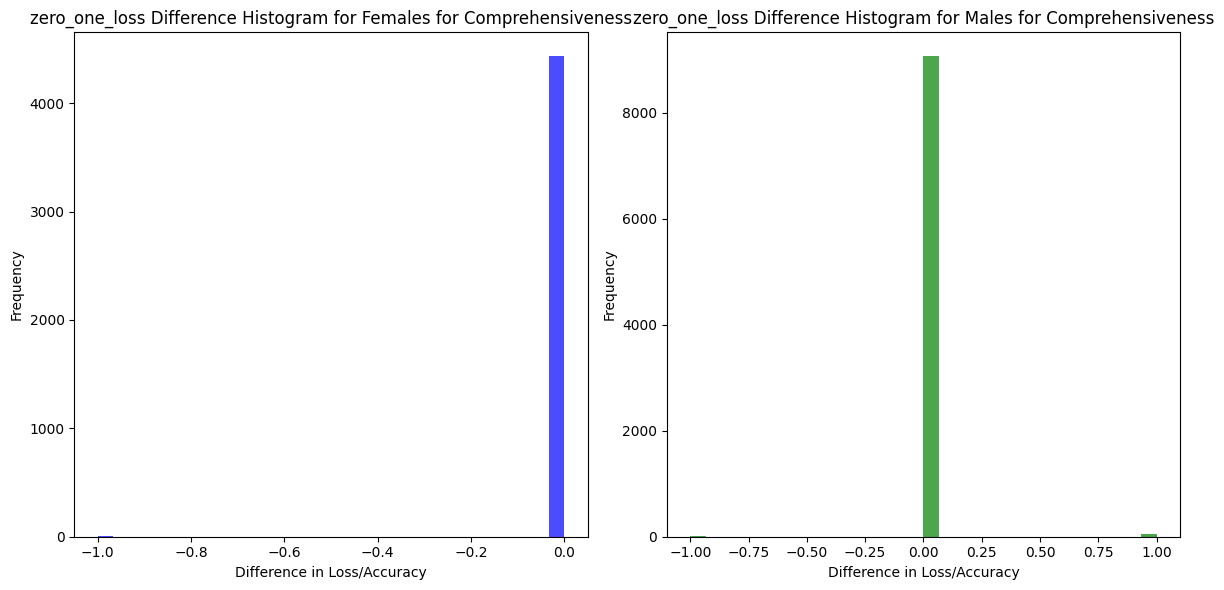

Model h_p - Female zero_one_loss: -0.0691, Male zero_one_loss: -0.2501
Model h_0 - Female zero_one_loss: -0.0713, Male zero_one_loss: -0.2478
Female loss difference -0.0023
Male loss difference 0.0023
Total loss h_p: -0.1908
Total loss h_0: -0.1900
Total loss difference: 0.0008
Number of females:  4443
Number of males 9124


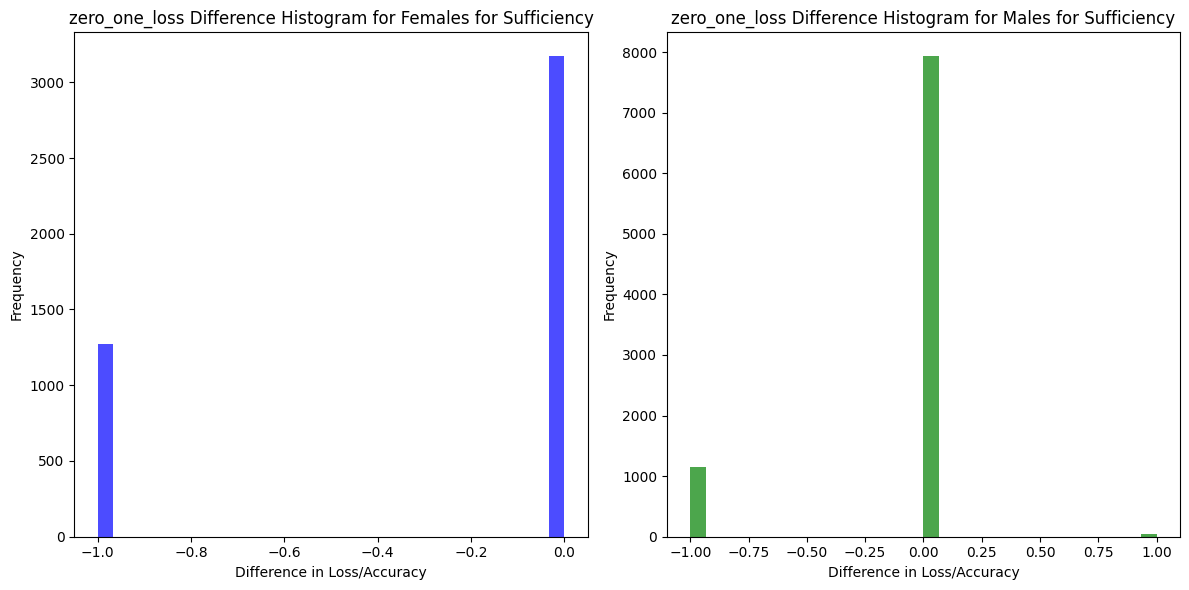

Model h_p - Female zero_one_loss: 0.6039, Male zero_one_loss: 0.5672
Model h_0 - Female zero_one_loss: 0.3176, Male zero_one_loss: 0.4457
Female loss difference -0.2863
Male loss difference -0.1214
Total loss h_p: 0.5792
Total loss h_0: 0.4038
Total loss difference: -0.1754
For training data explainer
Model h_p - Female zero_one_loss: -0.0725, Male zero_one_loss: -0.2556
Model h_0 - Female zero_one_loss: -0.0740, Male zero_one_loss: -0.2520
Female loss difference -0.0016
Male loss difference 0.0036
Total loss h_p: -0.1963
Total loss h_0: -0.1944
Total loss difference: 0.0019
Model h_p - Female zero_one_loss: 0.5948, Male zero_one_loss: 0.5693
Model h_0 - Female zero_one_loss: 0.3147, Male zero_one_loss: 0.4465
Female loss difference -0.2801
Male loss difference -0.1228
Total loss h_p: 0.5776
Total loss h_0: 0.4038
Total loss difference: -0.1738


In [56]:
top_k = 51  # Adjust the number of top features to remove
print("For test data explainer")
comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
plot_loss_difference_histogram(comprehensiveness_preds_h0, comprehensiveness_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Comprehensiveness")
hp_losses, h0_losses, female_loss_dif, male_loss_dif = compare_models_by_sex(comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, zero_one_loss, True)

# Step 6: Calculate sufficiency predictions and plot loss differences using 0-1 loss
sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)
plot_loss_difference_histogram(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Sufficiency")
hp_losses, h0_losses, female_loss_dif, male_loss_dif = compare_models_by_sex(sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, zero_one_loss)

print("For training data explainer")
comprehensiveness_preds_hp_train = comprehensiveness(model_hp, X_train_hp, attributions_hp_train, top_k)
comprehensiveness_preds_h0_train = comprehensiveness(model_h0, X_train_h0, attributions_h0_train, top_k)
hp_losses_train, h0_losses_train, _, _, = compare_models_by_sex(comprehensiveness_preds_hp_train, comprehensiveness_preds_h0_train, X_train_hp, y_preds_hp_train, y_preds_h0_train, zero_one_loss, True)

sufficiency_preds_hp_train = sufficiency(model_hp, X_train_hp, attributions_hp_train, top_k)
sufficiency_preds_h0_train = sufficiency(model_h0, X_train_h0, attributions_h0_train, top_k)
hp_losses_train, h0_losses_train, _, _, = compare_models_by_sex(sufficiency_preds_hp_train, sufficiency_preds_h0_train, X_train_hp, y_preds_hp_train, y_preds_h0_train, zero_one_loss)


Model h_p - Female zero_one_loss: -0.0439, Male zero_one_loss: -0.1635
Model h_0 - Female zero_one_loss: -0.0446, Male zero_one_loss: -0.1620
Female loss difference 0.0007
Male loss difference -0.0015
Total loss h_p: 0.1243
Total loss h_0: 0.1235
Total loss difference: 0.0008
Model h_p - Female zero_one_loss: 0.0666, Male zero_one_loss: 0.2442
Model h_0 - Female zero_one_loss: 0.0689, Male zero_one_loss: 0.2419
Female loss difference 0.0023
Male loss difference -0.0023
Total loss h_p: 0.1860
Total loss h_0: 0.1852
Total loss difference: -0.0008
Model h_p - Female zero_one_loss: -0.0691, Male zero_one_loss: -0.2501
Model h_0 - Female zero_one_loss: -0.0713, Male zero_one_loss: -0.2478
Female loss difference 0.0023
Male loss difference -0.0023
Total loss h_p: 0.1908
Total loss h_0: 0.1900
Total loss difference: 0.0008
Model h_p - Female zero_one_loss: 0.5985, Male zero_one_loss: 0.5647
Model h_0 - Female zero_one_loss: 0.3095, Male zero_one_loss: 0.4361
Female loss difference -0.2890
Mal

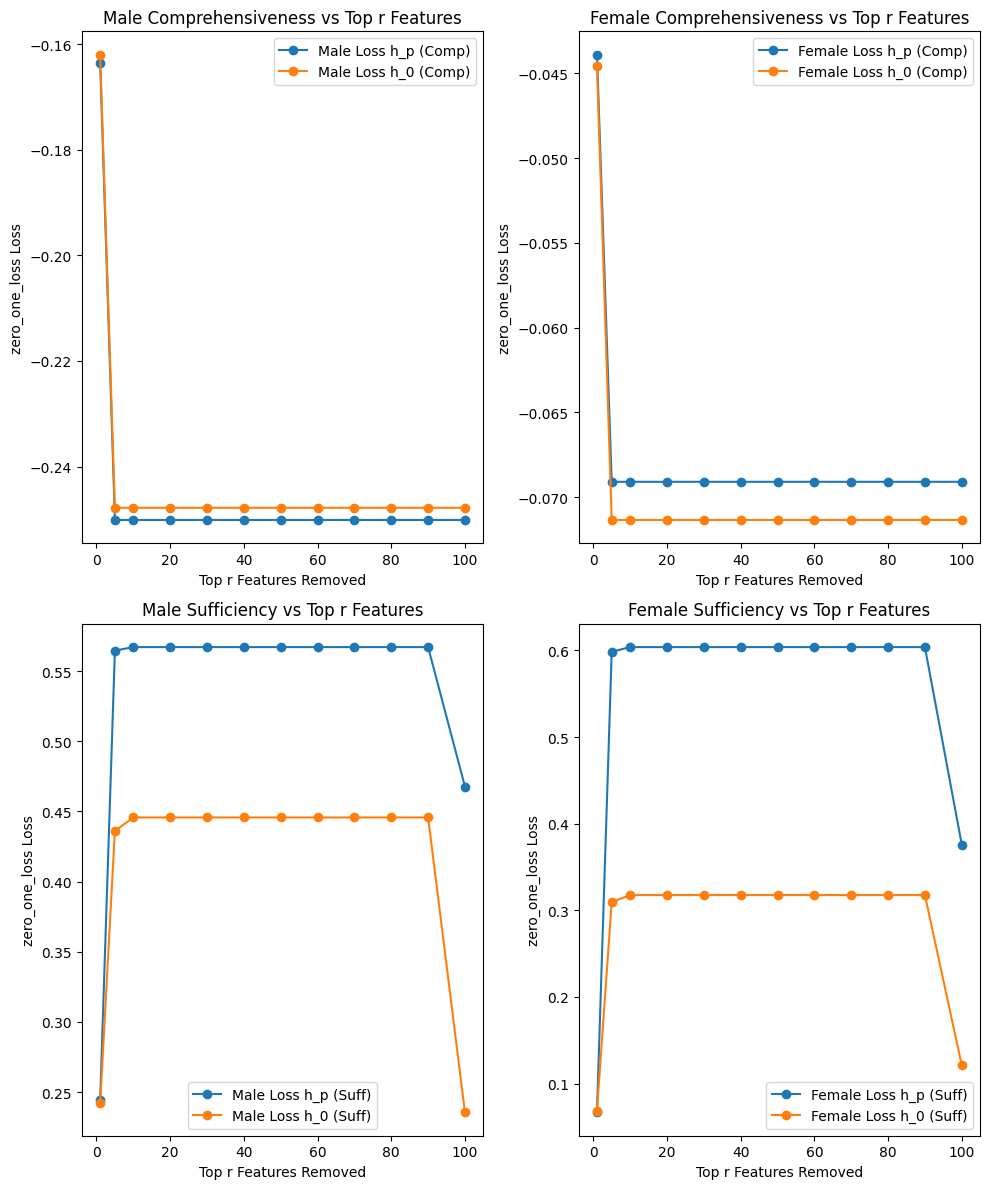

In [51]:
ks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plot_loss_by_sex_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, zero_one_loss, ks)

Full Run For Regression

Running regression task
Training and evaluating hp...
Early stopping triggered at epoch 59


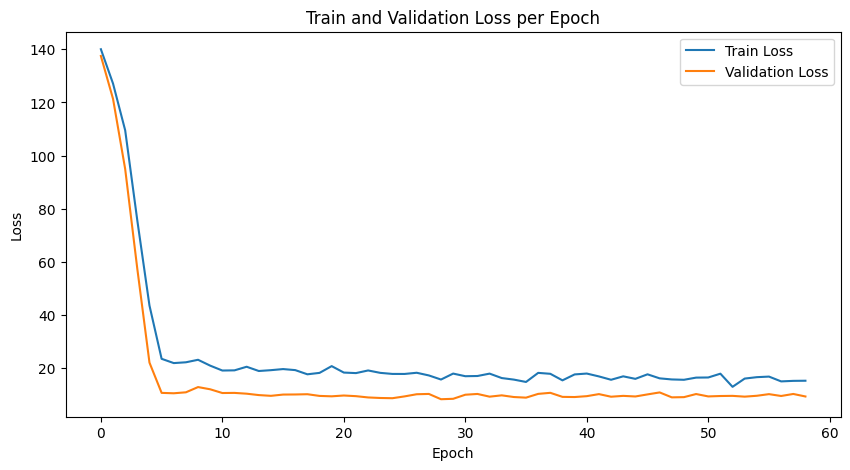

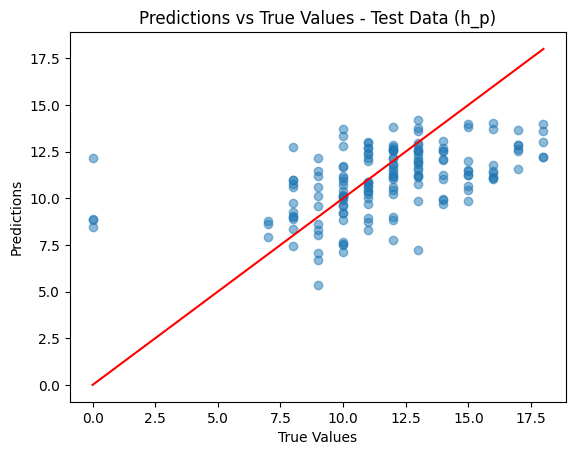

h_p - Training MSE: 7.8748
h_p - Test MSE: 8.2870
Training and evaluating h0...
Early stopping triggered at epoch 73


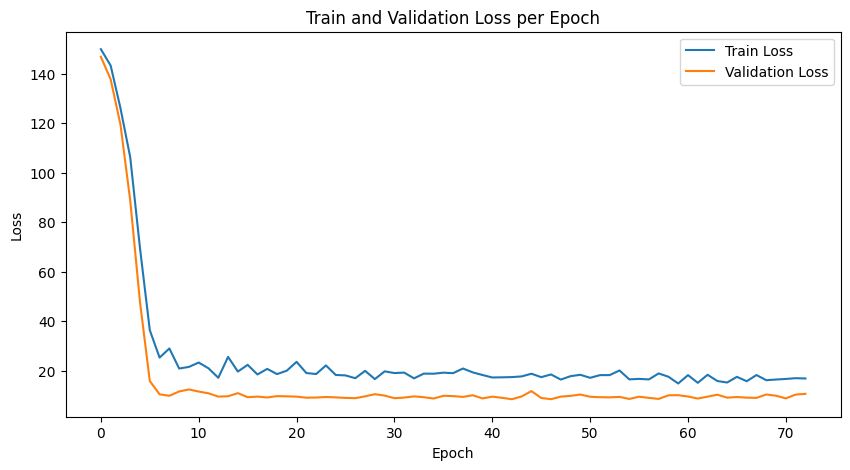

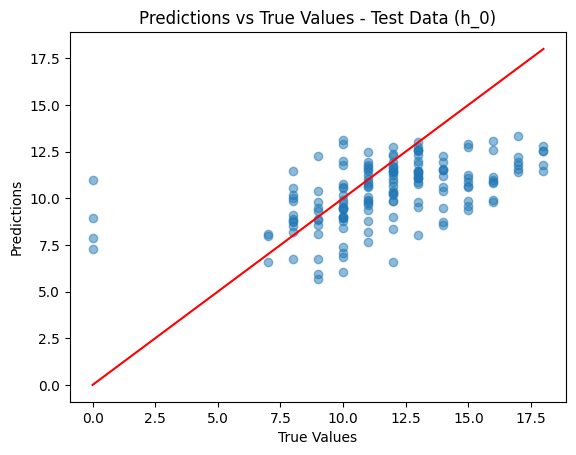

h_0 - Training MSE: 9.1229
h_0 - Test MSE: 9.3928


In [20]:
task_type = 'regression'
# Train and evaluate the models
X_train_hp_reg, X_test_hp_reg, y_train_reg, y_test_reg, X_train_h0_reg, X_test_h0_reg, model_hp_reg, model_h0_reg = train_and_evaluate_model(task_type)

For test data
Model h_p - Female squared_error: 8.9819, Male squared_error: 7.6092
Model h_0 - Female squared_error: 10.7601, Male squared_error: 8.0591
Female loss difference 1.7782
Male loss difference 0.4499
Total loss h_p: 8.2870
Total loss h_0: 9.3928
Total loss difference: 1.1058
For training data
Number of females:  187
Number of males:  185
Model h_p - Female squared_error: 6.9787, Male squared_error: 8.7805
Model h_0 - Female squared_error: 8.9312, Male squared_error: 9.3167
Female loss difference 1.9524
Male loss difference 0.5363
Total loss h_p: 7.8748
Total loss h_0: 9.1229
Total loss difference: 1.2482
Number of females:  79
Number of males 81
standard deviation for females:  6.959749604125583
Mean of male_loss_diff:  0.4499023470043231
standard deviation for males:  2.444822435687107


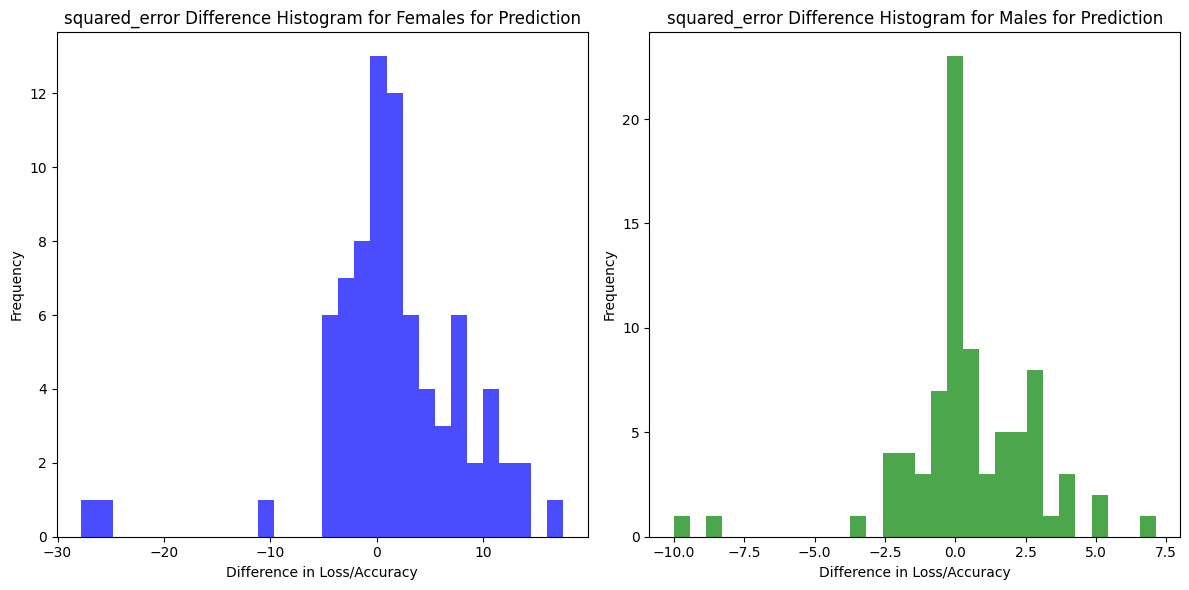

In [21]:
# Step 2: Generate predictions for both models - test
y_preds_hp_reg = predict_model(model_hp_reg, X_test_hp_reg)
y_preds_h0_reg = predict_model(model_h0_reg, X_test_h0_reg)

# Assume true values for both models are the same, if not, handle them separately
y_test_hp_reg = y_test_reg
y_test_h0_reg = y_test_reg

# Step 3: Compare models by sex using regression cost function (mean squared error)
print("For test data")
compare_models_by_sex(y_preds_hp_reg, y_preds_h0_reg, X_test_hp_reg, y_test_hp_reg, y_test_h0_reg, squared_error)
print("For training data")
y_preds_hp_train_reg = predict_model(model_hp_reg, X_train_hp_reg)
y_preds_h0_train_reg = predict_model(model_h0_reg, X_train_h0_reg)
print("Number of females: ", (X_train_hp_reg['sex_Female'] == 1).sum())
print("Number of males: ", (X_train_hp_reg['sex_Male'] == 1).sum())
y_train_hp_reg = y_train_reg
y_train_h0_reg = y_train_reg
compare_models_by_sex(y_preds_hp_train_reg, y_preds_h0_train_reg, X_train_hp_reg, y_train_hp_reg, y_train_h0_reg, squared_error)

# Step 4: Plot loss difference histograms for normal model predictions using mean squared error
plot_loss_difference_histogram(y_preds_h0_reg, y_preds_hp_reg, X_test_hp_reg, y_test_h0_reg, y_test_hp_reg, squared_error, "Prediction")

In [22]:
attributions_hp_reg, _ = explain_with_ig(model_hp_reg, X_test_hp_reg)
print()
attributions_h0_reg, _ = explain_with_ig(model_h0_reg, X_test_h0_reg)

# train data
attributions_hp_train_reg, _ = explain_with_ig(model_hp_reg, X_train_hp_reg)
attributions_h0_train_reg, _ = explain_with_ig(model_h0_reg, X_train_h0_reg)

Shape of attributions: torch.Size([160, 56])

Shape of attributions: torch.Size([160, 54])
Shape of attributions: torch.Size([372, 56])
Shape of attributions: torch.Size([372, 54])


For testing data explainer
Number of females:  79
Number of males 81
standard deviation for females:  0.0017264022903610593
Mean of male_loss_diff:  0.00032407857557784114
standard deviation for males:  0.002185935316565128


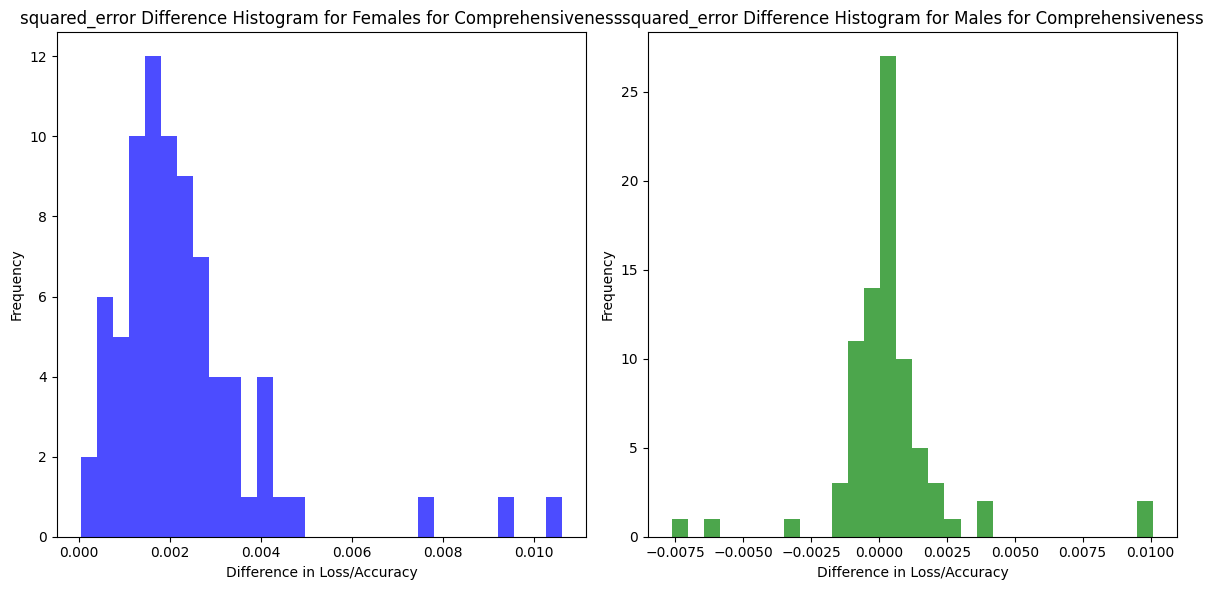

Model h_p - Female squared_error: 0.0103, Male squared_error: 0.0130
Model h_0 - Female squared_error: 0.0126, Male squared_error: 0.0133
Female loss difference 0.0023
Male loss difference 0.0003
Total loss h_p: 0.0102
Total loss h_0: 0.0113
Total loss difference: 0.0011
Number of females:  79
Number of males 81
standard deviation for females:  0.3136664477192656
Mean of male_loss_diff:  0.027496464167070148
standard deviation for males:  0.3689501635829257


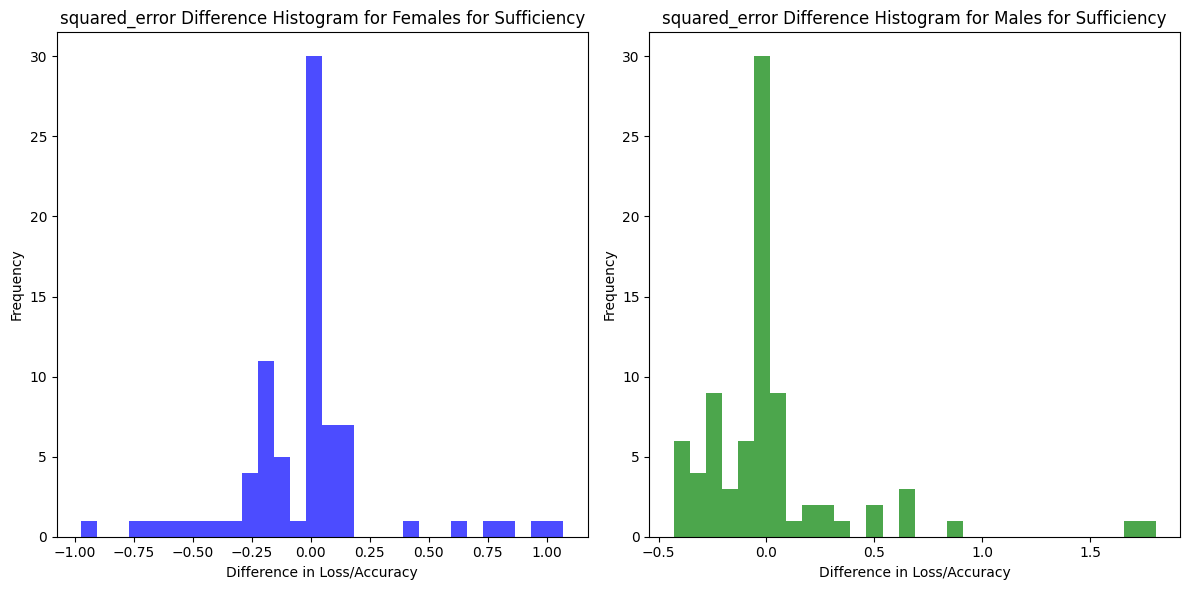

Model h_p - Female squared_error: 0.8787, Male squared_error: 1.1341
Model h_0 - Female squared_error: 0.8534, Male squared_error: 1.1616
Female loss difference -0.0253
Male loss difference 0.0275
Total loss h_p: 1.0080
Total loss h_0: 1.0094
Total loss difference: 0.0014
For training data explainer
Model h_p - Female squared_error: 0.0101, Male squared_error: 0.0128
Model h_0 - Female squared_error: 0.0121, Male squared_error: 0.0132
Female loss difference 0.0019
Male loss difference 0.0005
Total loss h_p: 0.0100
Total loss h_0: 0.0110
Total loss difference: 0.0010
Model h_p - Female squared_error: 0.6943, Male squared_error: 1.4398
Model h_0 - Female squared_error: 0.6572, Male squared_error: 1.6066
Female loss difference -0.0371
Male loss difference 0.1668
Total loss h_p: 1.0651
Total loss h_0: 1.1294
Total loss difference: 0.0643


In [23]:
top_k = 27  # Adjust the number of top features to remove

# Comprehensiveness for regression model h_p
print("For testing data explainer")
comprehensiveness_preds_hp_reg = comprehensiveness(model_hp_reg, X_test_hp_reg, attributions_hp_reg, top_k)
# Comprehensiveness for regression model h_0
comprehensiveness_preds_h0_reg = comprehensiveness(model_h0_reg, X_test_h0_reg, attributions_h0_reg, top_k)
# Plot loss difference for comprehensiveness between models
plot_loss_difference_histogram(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp_reg, y_preds_h0_reg, y_preds_hp_reg, squared_error, "Comprehensiveness")
hp_losses, h0_losses, female_loss_dif, male_loss_dif = compare_models_by_sex(comprehensiveness_preds_hp_reg, comprehensiveness_preds_h0_reg, X_test_hp_reg, y_preds_hp_reg, y_preds_h0_reg, squared_error, True)

# Step 6: Calculate sufficiency predictions and plot loss differences using mean squared error
sufficiency_preds_hp_reg = sufficiency(model_hp_reg, X_test_hp_reg, attributions_hp_reg, top_k)
sufficiency_preds_h0_reg = sufficiency(model_h0_reg, X_test_h0_reg, attributions_h0_reg, top_k)
# Plot loss difference for sufficiency between models
plot_loss_difference_histogram(sufficiency_preds_h0_reg, sufficiency_preds_hp_reg, X_test_hp_reg, y_preds_h0_reg, y_preds_hp_reg, squared_error, "Sufficiency")
hp_losses, h0_losses, female_loss_dif, male_loss_dif = compare_models_by_sex(sufficiency_preds_hp_reg, sufficiency_preds_h0_reg, X_test_hp_reg, y_preds_hp_reg, y_preds_h0_reg, squared_error)

print("For training data explainer")
comprehensiveness_preds_hp_train_reg = comprehensiveness(model_hp_reg, X_train_hp_reg, attributions_hp_train_reg, top_k)
comprehensiveness_preds_h0_train_reg = comprehensiveness(model_h0_reg, X_train_h0_reg, attributions_h0_train_reg, top_k)
hp_losses_train, h0_losses_train, _, _, = compare_models_by_sex(comprehensiveness_preds_hp_train_reg, comprehensiveness_preds_h0_train_reg, X_train_hp_reg, y_preds_hp_train_reg, y_preds_h0_train_reg, squared_error, True)

sufficiency_preds_hp_train_reg = sufficiency(model_hp_reg, X_train_hp_reg, attributions_hp_train_reg, top_k)
sufficiency_preds_h0_train_reg = sufficiency(model_h0_reg, X_train_h0_reg, attributions_h0_train_reg, top_k)
hp_losses_train, h0_losses_train, _, _, = compare_models_by_sex(sufficiency_preds_hp_train_reg, sufficiency_preds_h0_train_reg, X_train_hp_reg, y_preds_hp_train_reg, y_preds_h0_train_reg, squared_error)



Model h_p - Female squared_error: 0.9324, Male squared_error: 0.9253
Model h_0 - Female squared_error: 0.6738, Male squared_error: 0.6591
Female loss difference -0.2585
Male loss difference -0.2663
Total loss h_p: 0.9268
Total loss h_0: 0.6504
Total loss difference: -0.2764
Model h_p - Female squared_error: 105.3141, Male squared_error: 99.5659
Model h_0 - Female squared_error: 94.4676, Male squared_error: 97.3397
Female loss difference -10.8465
Male loss difference -2.2263
Total loss h_p: 103.1327
Total loss h_0: 95.5575
Total loss difference: -7.5752
Model h_p - Female squared_error: 0.0515, Male squared_error: 0.0514
Model h_0 - Female squared_error: 0.0480, Male squared_error: 0.0468
Female loss difference -0.0034
Male loss difference -0.0045
Total loss h_p: 0.0508
Total loss h_0: 0.0469
Total loss difference: -0.0040
Model h_p - Female squared_error: 47.2874, Male squared_error: 43.5015
Model h_0 - Female squared_error: 40.5301, Male squared_error: 41.9483
Female loss difference -

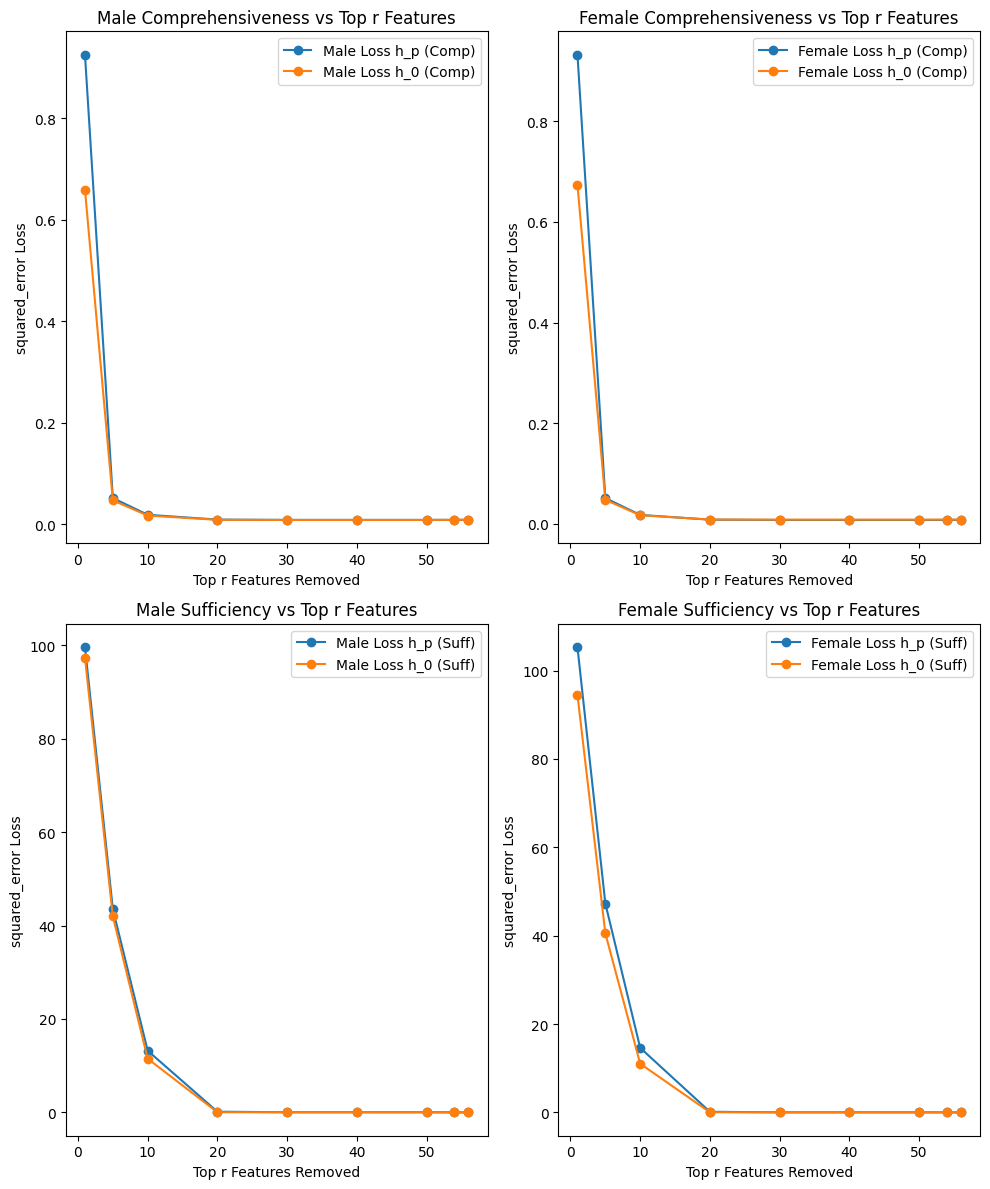

In [47]:
ks = [1, 5, 10, 20, 30, 40, 50, 54, 56]  # Example range of k values
plot_loss_by_sex_over_ks(model_hp_reg, model_h0_reg, X_test_hp_reg, X_test_h0_reg, y_preds_hp_reg, y_preds_h0_reg, attributions_hp_reg, attributions_h0_reg, squared_error, ks)

In [48]:
import pickle
import types
import io


to_save = {
    'X_train_hp': X_train_hp,
    'X_test_hp': X_test_hp,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_h0': X_train_h0,
    'X_test_h0': X_test_h0,
    'model_hp': model_hp,
    'model_h0': model_h0,

    # Regression versions of the variables
    'X_train_hp_reg': X_train_hp_reg,
    'X_test_hp_reg': X_test_hp_reg,
    'y_train_reg': y_train_reg,
    'y_test_reg': y_test_reg,
    'X_train_h0_reg': X_train_h0_reg,
    'X_test_h0_reg': X_test_h0_reg,
    'model_hp_reg': model_hp_reg,
    'model_h0_reg': model_h0_reg,

    # Attribution variables
    'attributions_hp_train': attributions_hp_train,
    'attributions_h0_train': attributions_h0_train,
    'attributions_hp': attributions_hp,
    'attributions_h0': attributions_h0,
    'attributions_hp_reg': attributions_hp_reg,
    'attributions_h0_reg': attributions_h0_reg,
    'attributions_hp_train_reg': attributions_hp_train_reg,
    'attributions_h0_train_reg': attributions_h0_train_reg
}
# Save the variables to a file
with open('variables.pkl', 'wb') as f:
    pickle.dump(to_save, f)

NameError: name 'X_train_hp' is not defined